In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Iterating over Deep Learning Models using Merlin Models

This notebook is created using the latest stable [merlin-tensorflow](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/merlin/containers/merlin-tensorflow/tags) container. 

In this example, we'll define several popular deep learning-based model architectures, train, and evaluate them and show how Merlin Models simplifies and eases this common and iterative process.

In this example notebook, we use synthetic dataset that is mimicking the Ali-CCP: Alibaba Click and Conversion Prediction dataset to build our recommender system models. ALI-CCP is a dataset gathered from real-world traffic logs of the recommender system in Taobao, the largest online retail platform in the world. To download the raw Ali-CCP training and test datasets visit [tianchi.aliyun.com](https://tianchi.aliyun.com/dataset/dataDetail?dataId=408#1). You can curate the raw dataset via this [get_aliccp() function](https://github.com/NVIDIA-Merlin/models/blob/main/merlin/datasets/ecommerce/aliccp/dataset.py#L43) and generated the parquet files to be used in this example.

### Learning objectives
- Preparing the data with NVTabular
- Training different deep learning-based recommender models with Merlin Models

## Importing Libraries

Let's start with importing the libraries that we'll use in this notebook.

In [ ]:
import os
import numpy as np

from nvtabular.loader.tf_utils import configure_tensorflow

configure_tensorflow()

import nvtabular as nvt
from nvtabular.ops import *
from merlin.models.utils.example_utils import workflow_fit_transform, save_results

from merlin.schema.tags import Tags

import merlin.models.tf as mm
from merlin.io.dataset import Dataset

import tensorflow as tf

## Feature Engineering with NVTabular

When we work on a new recommender systems, we explore the dataset, first. In doing so, we define our input and output paths. We will use the parquet files in the test folder to validate our trained model.

In [ ]:
from merlin.datasets.synthetic import generate_data

DATA_FOLDER = os.environ.get("DATA_FOLDER", "/workspace/data/")
NUM_ROWS = os.environ.get("NUM_ROWS", 1000000)
SYNTHETIC_DATA = eval(os.environ.get("SYNTHETIC_DATA", "True"))

if SYNTHETIC_DATA:
    train, valid = generate_data("aliccp-raw", int(NUM_ROWS), set_sizes=(0.7, 0.3))
    # save the datasets as parquet files
    train.to_ddf().to_parquet(os.path.join(DATA_FOLDER, "train"))
    valid.to_ddf().to_parquet(os.path.join(DATA_FOLDER, "valid"))

In [ ]:
train_path = os.path.join(DATA_FOLDER, "train", "*.parquet")
valid_path = os.path.join(DATA_FOLDER, "valid", "*.parquet")
output_path = os.path.join(DATA_FOLDER, "processed")

Our dataset has only categorical features. Below, we create continuous features using target encoding (TE) technique. Target Encoding calculates the statistics from a target variable grouped by the unique values of one or more categorical features. For example, in a binary classification problem, TE calculates the conditional probability that the target is true for each category value- a simple mean. To learn more about TE, visit this [medium blog](https://medium.com/rapids-ai/target-encoding-with-rapids-cuml-do-more-with-your-categorical-data-8c762c79e784).

Note that the `Ali-CCP` dataset has `click` and `conversion` target columns but we only focus on building different ranking models with binary target column `click`.

We use a utility function, `workflow_fit_transform` perform to fit and transform steps on the raw dataset applying the operators defined in the NVTabular workflow pipeline below, and also save our workflow model. After fit and transform, the processed parquet files are saved to `output_path`.

In [ ]:
%%time

user_id = ["user_id"] >> Categorify(freq_threshold=5) >> TagAsUserID()
item_id = ["item_id"] >> Categorify(freq_threshold=5) >> TagAsItemID()
add_feat = [
    "user_item_categories",
    "user_item_shops",
    "user_item_brands",
    "user_item_intentions",
    "item_category",
    "item_shop",
    "item_brand",
] >> Categorify()

te_feat = (
    ["user_id", "item_id"] + add_feat
    >> TargetEncoding(["click"], kfold=1, p_smooth=20)
    >> Normalize()
)

targets = ["click"] >> AddMetadata(tags=[Tags.BINARY_CLASSIFICATION, "target"])

outputs = user_id + item_id + targets + add_feat + te_feat

# Remove rows where item_id==0 and user_id==0
outputs = outputs >> Filter(f=lambda df: (df["item_id"] != 0) & (df["user_id"] != 0))

workflow_fit_transform(outputs, train_path, valid_path, output_path)

## Training Recommender Models

NVTabular exported the schema file of our processed dataset. The `schema.pbtxt` is a protobuf text file contains features metadata, including statistics about features such as cardinality, min and max values and also tags based on their characteristics and dtypes (e.g., categorical, continuous, list, item_id). The metadata information is loaded from schema and their tags are used to automatically set the parameters of Merlin Models. In other words, Merlin Models relies on the schema object to automatically build all necessary input and output layers.

In [ ]:
train = Dataset(os.path.join(output_path, "train", "*.parquet"), part_size="500MB")
valid = Dataset(os.path.join(output_path, "valid", "*.parquet"), part_size="500MB")

# define schema object
schema = train.schema

In [ ]:
target_column = schema.select_by_tag(Tags.TARGET).column_names[0]
target_column

We can print out all the features that are included in the `schema.pbtxt` file.

In [ ]:
schema.column_names

### Initialize Dataloaders

We're ready to start training, for that, we create our dataset objects, and under the hood we use Merlin `BatchedDataset` class for reading chunks of parquet files. `BatchedDataset` asynchronously iterate through CSV or Parquet dataframes on GPU by leveraging an NVTabular `Dataset`. To read more about Merlin optimized dataloaders visit [here](https://github.com/NVIDIA-Merlin/models/blob/main/merlin/models/tf/dataset.py#L141).

### NCF Model

We will first build and train a Neural Collaborative Filtering (NCF) model. Neural Collaborative Filtering [(NCF)](https://arxiv.org/pdf/1708.05031.pdf) Model  architecture explores neural network architectures for collaborative filtering, in other words explores the use of deep neural networks for learning the interaction function from data.

NCF feed categorical features into embedding layer, concat the embedding outputs and add multiple hidden layers via its MLP layer tower as seen in the figure. GMF and MLP uses separate user and item embeddings, and then outputs of their interactions from GMF Layer and MLP Layer are concatenated and fed to the final NeuMF (Neural Matrix Factorisation) layer.

<img src="./images/ncf.png"  width="30%">

<a href="https://arxiv.org/pdf/1708.05031.pdf">Image Source: NCF paper</a>

With `schema` object we enable NCF model easily to recognize item_id and user_id columns (defined in the schema.pbtxt with corresponding tags). Input block of embedding layers will be generated using item_id and user_id as seen in the Figure.

In [ ]:
model = mm.benchmark.NCFModel(
    schema,
    embedding_dim=64,
    mlp_block=mm.MLPBlock([128, 64]),
    prediction_tasks=mm.BinaryClassificationTask(target_column),
)

In [ ]:
%%time
batch_size = 16 * 1024
LR = 0.03

opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False, metrics=[tf.keras.metrics.AUC()])
model.fit(train, validation_data=valid, batch_size=batch_size)

Let's save our accuracy results

In [ ]:
if os.path.isfile("results.txt"):
    os.remove("results.txt")

In [ ]:
save_results("NCF", model)

Let's check out the model evaluation scores

In [ ]:
metrics_ncf = model.evaluate(valid, batch_size=1024, return_dict=True)
metrics_ncf

### MLP Model

Now we will change our model to Multi-Layer Percepton (MLP) model. MLP models feed categorical features into embedding layer, concat the embedding outputs and add multiple hidden layers.

<img src="./images/mlp.png"  width="30%">

Steps:

- Change the model to MLP model
- Rerun the pipeline from there from model.fit

In [ ]:
# uses default embedding_dim = 64
model = mm.Model.from_block(mm.MLPBlock([64, 32]),
    schema, prediction_tasks=mm.BinaryClassificationTask(target_column)
)

In [ ]:
%%time

opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False, metrics=[tf.keras.metrics.AUC()])
model.fit(train, validation_data=valid, batch_size=batch_size)

In [ ]:
save_results("MLP", model)

Let's check out the model evaluation scores

In [ ]:
metrics_mlp = model.evaluate(valid, batch_size=1024, return_dict=True)
metrics_mlp

### DLRM Model

Deep Learning Recommendation Model [(DLRM)](https://arxiv.org/abs/1906.00091) architecture is a popular neural network model originally proposed by Facebook in 2019 as a personalization deep learning model.

![DLRM](./images/DLRM.png)


DLRM accepts two types of features: categorical and numerical. 
- For each categorical feature, an embedding table is used to provide dense representation to each unique value. 
- For numerical features, they are fed to model as dense features, and then transformed by a simple neural network referred to as "bottom MLP". This part of the network consists of a series of linear layers with ReLU activations. 
- The output of the bottom MLP and the embedding vectors are then fed into the dot product interaction operation (see Pairwise interaction step). The output of "dot interaction" is then concatenated with the features resulting from the bottom MLP (we apply a skip-connection there) and fed into the "top MLP" which is also a series of dense layers with activations ((a fully connected NN). 
- The model outputs a single number (here we use sigmoid function to generate probabilities) which can be interpreted as a likelihood of a certain user clicking on an ad, watching a movie, or viewing a news page.


Steps:<br>
* Change the model to `DLRMModel`
* Rerun the pipeline from there from model.fit

In [ ]:
model = mm.DLRMModel(
    schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.BinaryClassificationTask(target_column),
)

In [ ]:
%%time
opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False, metrics=[tf.keras.metrics.AUC()])
model.fit(train, validation_data=valid, batch_size=batch_size)

In [ ]:
save_results("DLRM", model)

Let's check out the model evaluation scores

In [ ]:
metrics_dlrm = model.evaluate(valid, batch_size=1024, return_dict=True)
metrics_dlrm

### DCN Model

DCN-V2 is an architecture proposed as an improvement upon the original [DCN model](https://arxiv.org/pdf/1708.05123.pdf). The explicit feature interactions of the inputs are learned through cross layers, and then combined with a deep network to learn complementary implicit interactions. The overall model architecture is depicted in Figure below, with two ways to combine the cross network with the deep network: (1) stacked and (2) parallel. The output of the embbedding layer is the concatenation of all the embedded vectors and the normalized dense features: x<sub>0</sub> = [x<sub>embed,1</sub>; . . . ; x<sub>embed,𝑛</sub>; 𝑥<sub>dense</sub>].

![DCN](./images/DCN.png)

<a href="https://arxiv.org/abs/2008.13535">Image Source: DCN V2 paper</a>

In this example, we build `DCN-v2 stacked` architecture. 

Steps:<br>
* Change the model to `DCNModel`
* Rerun the pipeline from there to model.fit

In [ ]:
model = mm.DCNModel(
    schema,
    depth=2,
    deep_block=mm.MLPBlock([64, 32]),
    prediction_tasks=mm.BinaryClassificationTask(target_column),
)

In [ ]:
%%time
opt = tf.keras.optimizers.Adagrad(learning_rate=LR)
model.compile(optimizer=opt, run_eagerly=False, metrics=[tf.keras.metrics.AUC()])
model.fit(train, validation_data=valid, batch_size=batch_size)

In [ ]:
save_results("DCN", model)

Let's check out the model evaluation scores

In [ ]:
metrics_dcn = model.evaluate(valid, batch_size=1024, return_dict=True)
metrics_dcn

Let's visualize our model validation accuracy values. Since we did not do any hyper-parameter optimization or extensive feature engineering here, we do not come up with a final conclusion that one model is superior to another.

In [ ]:
import matplotlib.pyplot as plt


def create_bar_chart(text_file_name, models_name):
    """a func to plot barcharts via parsing the  accuracy results in a text file"""
    auc = []
    with open(text_file_name, "r") as infile:
        for line in infile:
            if "auc" in line:
                data = [line.rstrip().split(":")]
                key, value = zip(*data)
                auc.append(float(value[0]))

    X_axis = np.arange(len(models_name))

    plt.title("Models' accuracy metrics comparison", pad=20)
    plt.bar(X_axis - 0.2, auc, 0.4, label="AUC")

    plt.xticks(X_axis, models_name)
    plt.xlabel("Models")
    plt.ylabel("AUC")
    plt.show()

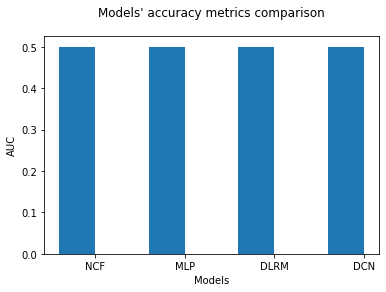

In [27]:
models_name = ["NCF", "MLP", "DLRM", "DCN"]
create_bar_chart("results.txt", models_name)

Let's remove the results file.

In [28]:
if os.path.isfile("results.txt"):
    os.remove("results.txt")